<a href="https://colab.research.google.com/github/DenizY98/pydemo/blob/main/SamstagVersionFallstudie1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prozessoptimierung - Fallstudie

##PIP, OR-Tools und Pandas

In [1]:
# Importieren der benötigten Bibliotheken
!pip install -U -q pip
!pip install -q ortools

In [2]:
# Laden des Programms
from ortools.linear_solver import pywraplp
import pandas as pd
# Initialisieren des Solvers
solver = pywraplp.Solver.CreateSolver('SCIP')

In [3]:
! git clone https://github.com/AlexKressner/Industrielles_Management

fatal: destination path 'Industrielles_Management' already exists and is not an empty directory.


In [4]:
path = "Industrielles_Management/Daten/Fallstudie/"

##Ziel:
Maximierung der bedienten Nachfrage innerhalb der vorgegebenen Lieferzeit und des Budgets.


##Daten:


In [5]:
#dataframes laden aus Daten der CSV-Dateien
nachfrage_df = pd.read_csv(f"{path}/FLINK_Nachfrage.csv", sep=";", index_col=0) # Da Indizes in Datenquelle so festgelegt
standorte_df = pd.read_csv(f"{path}/FLINK_Standorte.csv", sep=";")

###Indexmengen:


###Indexmengen:
$ Q = \{q \mid q = (i,j), i \in \{0, \ldots, 12\}, j \in \{0, \ldots, 12\}\} $
Menge aller Quadranten $ q $ als $( i , j )$ Tupel


$ S = \{s \mid s \in \{0, \ldots, 9\}\} $
Menge aller potentieller DarkStores $ s $

In [6]:
Q = [(i, j) for i in range(nachfrage_df.shape[0]) for j in range(nachfrage_df.shape[1])]  # Menge aller Quadranten q als (i, j) Tupel
S = standorte_df['Potenzielle_Standorte'].to_list()  # Menge aller potentieller DarkStores

###Variablen:
$ x_s \in \{0,1\} \: \quad \forall s \in S $: Binärvariable, die angibt, ob am Standort $ s $ ein Dark Store eingerichtet wird $1$ oder nicht $0$.

$ y_{qs} \in \{0,1\} \quad \forall q \in Q, \forall s \in S $: Binärvariable, die angibt, ob Dark Store Standort $ s $ den Quadranten $ q $ beliefert $1$ oder nicht $0$.

$ z_{qs} \in \{0,\infty\} \: \: \: \forall q \in Q, \forall s \in S$: Int-Variable, die die absolute Liefermenge von Darkstore $ s $ an Quadranten $ q (i,j) $ repräsentiert.


In [7]:
# Wird der store s errichtet? (0,1)
x = {}
for s in S:
  x[s] = solver.BoolVar(f'x[{s}]')

In [8]:
# Liefert der Store s an Quadranten Q? (0,1)
y = {}
for s in S:
    for q in Q:
        y[q, s] = solver.BoolVar(f'y[{q},{s}]')

In [9]:
# Wie viel Nachfrage deckt jeder Store s fuer einen Quadraten Q ab? (0-Infinity)
z = {}
for s in S:
    for q in Q:
        z[q, s] = solver.IntVar(0, solver.infinity(), f'z[{q},{s}]')

###Parameter:


In [10]:
#Standorte Dataframe
Lagerumschlagleistung = standorte_df.set_index('Potenzielle_Standorte')['Lagerumschlagleistung'].to_dict()
Errichtungskosten = standorte_df.set_index('Potenzielle_Standorte')['Errichtungskosten'].to_dict()
Koordinaten = standorte_df.set_index('Potenzielle_Standorte')[['i_Koordinate','j_Koordinate']].to_dict('index')

###Parameter:

$ D_q $: Nachfrage im Quadranten $ q $ als Bestellungen pro Tag.

$ L_s $: Lagerumschlagleistung des Standorts $ s $ als Bestellungen pro Tag.

$ C_s $: Kosten für die Einrichtung eines Dark Stores am Standort $ s $.

$ G $: Geschwindigkeit des Fahrradkuriers in KM/h.

$ B $: Gesamtbudget für die Einrichtung von Dark Stores.

$ T $: Maximale Lieferzeit.

$ TV $: Verbleibende Lieferzeit abzüglich aller Zeitfresser.

$ A $: Maximale Anzahl von Quadranten, die ein Fahrradkurier bedienen kann.

In [11]:
D = {q: nachfrage_df.iat[q[1],q[0]] for q in Q} # Quadratennachfrage D[q] die Nachfrage an Quadrant Koordinaten q_zeilen, q_spalten
L = {s: Lagerumschlagleistung[s] for s in S}  # Lagerumschlagleistung L[s] des Standorts s als Bestellungen pro Tag
C = {s: Errichtungskosten[s] for s in S}  # Kosten für die Einrichtung C[s] eines Dark Stores am Standort s
B = 1000000  # Gesamtbudget B für die Einrichtung von Dark Stores
G = 25  # Geschwindigkeit G (km/h)
T = 10  # Maximale Lieferzeit T (min)
TF1= 3  # Zeit fuer Warenbereitstellung TF1
TF2= 1  # Zeit fuer Warenuebergabe TF2
TV= (T-TF1-TF2) # Verbleibende Lieferzeit TV
A = round((TV/2)/0.25*G/60, None) # max Reichweite in Quadranten für eine Richtung

###Zielfunktion:


Maximiere die gesamte bediente Nachfrage:

$ \text{Max} \sum_{qs} z_{qs} $

In [12]:
# Maximiere die variable Liefermenge z[q,s]
solver.Maximize(solver.Sum([z[q, s] for q in Q for s in S]))


###Restriktionen:

In [13]:
# Ein Store kann nur liefern, falls er errichtet wurde und darf maximal die nachgefragte Menge liefern
for s in S:
    for q in Q:
        solver.Add(y[q, s] <= x[s])
        solver.Add(z[q, s] <= D[q] * y[q, s])

In [14]:
# Falls der Standort s and Quadrant q liefert, muss die Summe über alle s genau der nachgefragten Menge entsprechen
for q in Q:
    solver.Add(solver.Sum([z[q, s] for s in S]) <= D[q])

In [15]:
# Nachfragerestriktion 1: Es dürfen nicht mehr als 2 Darkstores einen Quadranten beliefern
for q in Q:
    solver.Add(solver.Sum([y[q, s] for s in S]) <= 2)

In [16]:
# Lagerumschlagleistungsrestriktionen: Fuer jeden Store pruefen ob die Summe der bedienten Nachfrage kleiner ist als die Kapazitaet des Stores L[s]
# mit x[s] wird zudem geprueft ob der store gebaut ist oder nicht
for s in S:
    solver.Add(solver.Sum([z[q, s] for q in Q]) <= x[s] * L[s])

In [17]:
# Reichweitenrestriktion für Fahrradkuriere
for s in S:
    for q in Q:
        # Berechnung der Manhattan-Distanz zwischen dem Standort s und dem Quadranten q
        distance = abs(Koordinaten[s]['i_Koordinate'] - q[0]) + abs(Koordinaten[s]['j_Koordinate'] - q[1])
        if distance > 5:
            solver.Add(y[q, s] == 0)

In [18]:
# Budgetrestriktion
solver.Add(solver.Sum([x[s] * C[s] for s in S]) <= B)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x7ad0b5400cc0> >

###Loesung:

In [19]:
# Lösen des Modells
status = solver.Solve()

In [20]:
if status == pywraplp.Solver.OPTIMAL:
    gesamtnachfrage = sum(D.values())
    ausgelieferte_waren = sum(z[q, s].solution_value() for q in Q for s in S if z[q, s].solution_value() > 0)
    print(f'Prozentuale Erfüllung der Gesamtnachfrage: {round((ausgelieferte_waren/gesamtnachfrage*100), ndigits=2)}%')
    print('Lösung gefunden:')
    print('Zielfunktionswert (Kosten) =', solver.Objective().Value())
    for s in S:
        if x[s].solution_value() == 1:
            print(f'Standort {s} wird eingerichtet.')
            vollstaendig = [q for q in Q if z[q, s].solution_value() > 0 and z[q, s].solution_value() == D[q]]
            if vollstaendig:
                print(f'Vollständige Lieferungen von Standort {s} mit {", ".join(str(q) for q in vollstaendig)} vollständig beliefert.')
            teilweise = [(q, round(z[q, s].solution_value()/D[q]*100)) for q in Q if z[q, s].solution_value() > 0 and z[q, s].solution_value() != D[q]]
            if teilweise:
                print(f'Teilweise Lieferungen von Standort {s} mit {", ".join(f"{q[0]} ({q[1]}%)" for q in teilweise)} beliefert.')
else:
    print('Keine optimale Lösung gefunden.')

Prozentuale Erfüllung der Gesamtnachfrage: 87.4%
Lösung gefunden:
Zielfunktionswert (Kosten) = 7515.000000000001
Standort 1 wird eingerichtet.
Vollständige Lieferungen von Standort 1 mit (4, 12), (6, 12), (7, 12), (8, 10), (10, 10), (11, 11), (11, 12), (12, 10), (12, 12) vollständig beliefert.
Teilweise Lieferungen von Standort 1 mit (8, 8) (9%), (9, 9) (25%) beliefert.
Standort 2 wird eingerichtet.
Vollständige Lieferungen von Standort 2 mit (8, 1), (8, 2), (9, 0), (9, 1), (10, 0), (10, 2), (10, 3), (11, 0), (11, 1), (11, 2), (12, 1) vollständig beliefert.
Teilweise Lieferungen von Standort 2 mit (10, 1) (26%) beliefert.
Standort 3 wird eingerichtet.
Vollständige Lieferungen von Standort 3 mit (7, 10), (7, 11), (8, 11), (8, 12), (9, 7), (9, 8), (9, 10), (9, 11), (9, 12), (10, 9), (10, 11), (10, 12), (11, 9), (11, 10), (12, 7), (12, 8), (12, 11) vollständig beliefert.
Teilweise Lieferungen von Standort 3 mit (9, 9) (75%), (10, 6) (91%) beliefert.
Standort 4 wird eingerichtet.
Vollständ

### Darstellung als Matrix, DF oder MatPlot

In [25]:
import numpy as np
import pandas as pd

# Erstellen Sie eine leere Matrix der gleichen Größe wie Ihr Quadrantengitter
ergebnis_matrix = np.empty((14, 14), dtype=object)  # Größe angepasst, um Store i_Koordinate von 13 zu berücksichtigen

# Füllen Sie die Matrix mit den Ergebnissen Ihres Modells
for s in S:
    if x[s].solution_value() > 0:  # Wenn ein Darkstore an diesem Standort errichtet wurde
        for q in Q:
            if y[q, s].solution_value() == 1:  # Wenn der Standort s den Quadranten q beliefert
                if z[q, s].solution_value() == D[q]:  ergebnis_matrix[q[0], q[1]] = str(s) # Wenn die gelieferte Menge gleich der Nachfrage ist
                else:
                  if ergebnis_matrix[q[0], q[1]] is not None: ergebnis_matrix[q[0], q[1]] += '' + str(s)



# Nachdem alle Quadranten bedient wurden, gehen Sie erneut über alle Standorte in S
for s in S:
    if x[s].solution_value() == 1:  # Wenn ein Darkstore an diesem Standort errichtet wurde
        i, j = Koordinaten[s]['i_Koordinate'], Koordinaten[s]['j_Koordinate']
        if 0 <= i < 14 and 0 <= j < 14:  # Stellen Sie sicher, dass die Koordinaten innerhalb der Matrix liegen
            ergebnis_matrix[i, j] = "S" + str(s)

# Konvertieren Sie die Matrix in einen DataFrame für eine schönere Darstellung
ergebnis_df = pd.DataFrame(ergebnis_matrix).transpose()
ergebnis_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,None,None,None,9,9,9,None,None,None,2,2,2,None,None
1,None,None,9,9,7,9,9,None,2,2,None,2,2,None
2,None,9,9,9,9,79,9,9,2,None,2,2,4,None
3,9,9,9,7,9,79,7,9,9,None,2,4,4,None
4,9,7,7,7,S9,9,9,7,9,9,S2,4,4,None
5,9,7,7,7,7,7,7,7,9,4,4,4,4,None
6,7,7,7,9,S7,7,7,7,7,7,None,4,4,S4
7,7,7,7,9,7,7,9,7,7,3,4,4,3,None
8,5,7,7,7,S5,9,7,7,None,3,4,4,3,None
9,5,5,7,7,7,7,7,5,5,None,3,3,4,None


####Visualisierung

<ipython-input-26-0f6addd9e5e7>:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  num_matrix = num_matrix.fillna(-1)


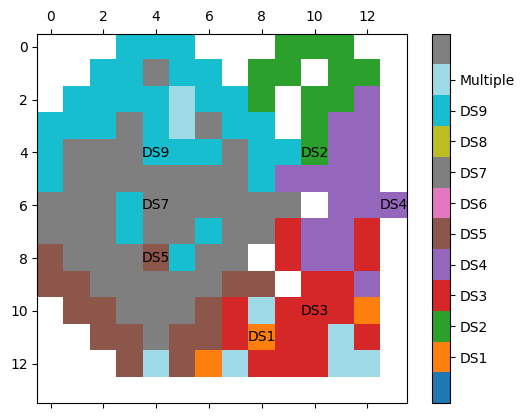

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Erstellen Sie eine Kopie der Ergebnismatrix, in der die Darkstores und Quadranten durch eindeutige numerische Werte repräsentiert werden
num_matrix = ergebnis_df.copy()
for i in range(14):
    for j in range(14):
        if num_matrix.iloc[i, j] is not None and isinstance(num_matrix.iloc[i, j], str):
            if "S" in num_matrix.iloc[i, j]:
                num_matrix.iloc[i, j] = int(num_matrix.iloc[i, j].replace("S", ""))
            else:
                num_matrix.iloc[i, j] = int(num_matrix.iloc[i, j])
# Ersetzen Sie None-Werte durch einen speziellen numerischen Wert
num_matrix = num_matrix.fillna(-1)
# Ersetzen Sie den speziellen numerischen Wert durch NaN
num_matrix[num_matrix == -1] = np.nan
# Ersetzen Sie alle int Werte über 10 durch -2
num_matrix[num_matrix > 10] = 10
# Create a new color map with an extra color for the '10' value
cmap = plt.get_cmap('tab20', int(np.nanmax(num_matrix) - np.nanmin(num_matrix) + 2))  # 'tab20' provides 20 distinct colors
# Set the color for 'None' and '10'
cmap.set_under('white')  # For 'None'
cmap.set_over('gray')  # For '10'
# Erstellen Sie eine Abbildung und eine Achse
fig, ax = plt.subplots()
cax = ax.matshow(num_matrix, cmap=cmap, vmin=0)  # Setzen Sie vmin auf 0, um die untere Grenze der Farbkarte festzulegen
# Create the colorbar with custom boundaries
cbar = fig.colorbar(cax, ticks=np.arange(np.nanmin(num_matrix), np.nanmax(num_matrix)+1), boundaries=np.arange(-0.5, np.nanmax(num_matrix)+2.5))  # +2.5 to include '10' and 'None'
# Set the labels
labels = ['DS'+str(i) for i in range(int(np.nanmin(num_matrix)), int(np.nanmax(num_matrix)))] + ['Multiple']  # Add labels for 'None' and '10'
cbar.ax.set_yticklabels(labels)
# Zeichnen Sie ein 'X' in die Zellen, die einen Darkstore repräsentieren
for s in S:
    if x[s].solution_value() == 1:
        j, i = Koordinaten[s]['i_Koordinate'], Koordinaten[s]['j_Koordinate']
        if 0 <= i < 14 and 0 <= j < 14:  # Stellen Sie sicher, dass die Koordinaten innerhalb der Matrix liegen
            plt.text(j, i, f'DS{str(s)}', ha='center', va='center', color='black')

# Zeigen Sie das Bild an
plt.show()